In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
sns.set_theme()

# Read Data

In [2]:
posterior_files = [
    'mouse_results/npMSL/posteriors_1_5_npMSL_it_10000_k_17_original-k_17_.csv',
    'mouse_results/poisson/poisson_cluster_19_posterior.csv',
    'mouse_results/transformation/logitTransform_cluster_posterior_25_.csv'
]
method_names = [
    'npMSL',
    'Poisson',
    'Logit Transformation'
]

fig_sizes = (7,7)

# Plot graphs

In [3]:
i = 2

filename = posterior_files[i]
method = method_names[i]

In [4]:
data = pd.read_csv(filename, index_col = 0)
posteriors = data.values
data['cluster'] = np.argmax(posteriors, axis = 1) + 1
data['max probability'] = np.max(posteriors, axis = 1)
data['>0.8'] = data['max probability'] > 0.8
data['occurence'] = 1
data.head()

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,...,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,cluster,max probability,>0.8,occurence
ENSMUSG00000000001,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.000,0.145,13,0.778,False,1
ENSMUSG00000000028,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,...,0.235,0.000,0.0,0.000,0.000,0.502,25,0.502,False,1
ENSMUSG00000000031,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,...,0.000,0.002,0.0,0.992,0.005,0.000,23,0.992,True,1
ENSMUSG00000000049,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.000,0.000,12,1.000,True,1
ENSMUSG00000000056,0.0,0.0,0.0,0.0,0.151,0.0,0.007,0.0,0.0,0.0,...,0.000,0.841,0.0,0.000,0.000,0.000,21,0.841,True,1


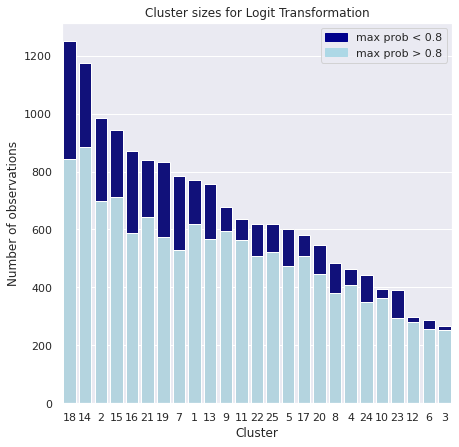

In [5]:
plt.figure(figsize=fig_sizes)
total = data.groupby('cluster')['occurence'].sum().reset_index()
bar1 = sns.barplot(x="cluster",  y="occurence", data=total, color='darkblue', order = list(data.cluster.value_counts().index))
smoker = data[data['>0.8']==True]
bar2 = sns.barplot(x="cluster", y="occurence", data=smoker, estimator=sum, ci=None,  color='lightblue', order = list(data.cluster.value_counts().index))
top_bar = mpatches.Patch(color='darkblue', label='max prob < 0.8')
bottom_bar = mpatches.Patch(color='lightblue', label='max prob > 0.8')
plt.legend(handles=[top_bar, bottom_bar])
plt.ylabel("Number of observations")
plt.xlabel("Cluster")
plt.title("Cluster sizes for {}".format(method))
plt.savefig('graphs/{}_bar_plot.png'.format(method), dpi = 500)
# show the graph
plt.show()


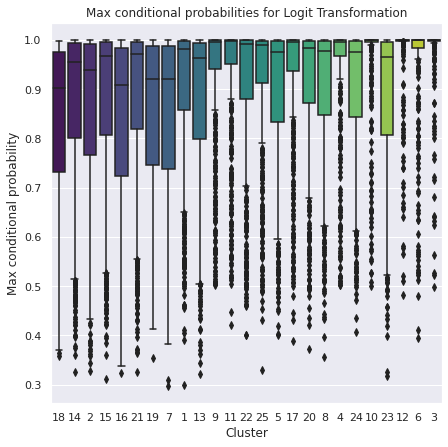

In [6]:
plt.figure(figsize=fig_sizes)
g = sns.boxplot(data= data, y = 'max probability', x = 'cluster', order = list(data.cluster.value_counts().index), palette = 'viridis' );
plt.ylabel("Max conditional probability");
plt.xlabel("Cluster");
plt.title("Max conditional probabilities for {}".format(method));
plt.savefig('graphs/{}_box_plot.png'.format(method), dpi = 500)

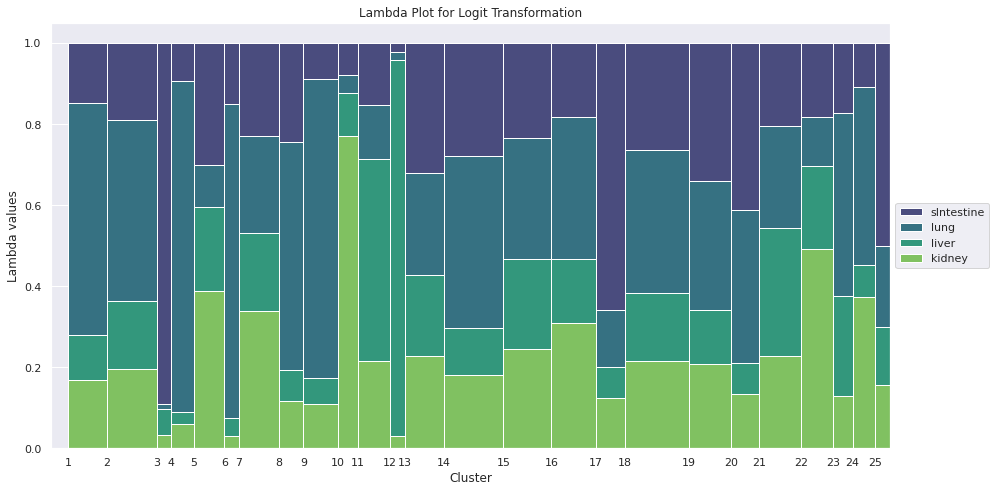

In [7]:
raw_counts = pd.read_csv('raw_counts_mouse.csv', index_col = 0)
data_points_percentage = raw_counts.loc[data.index,].copy()
data_points_percentage['label'] = data.cluster.values
data_percentages = data_points_percentage.groupby('label').sum()

data_percentages_replicates = pd.DataFrame({})
number_of_repetitions = 2
for index,col in enumerate(['kidney','liver','lung','sIntestine']):
    new_col = np.sum(data_percentages.values[:,number_of_repetitions*index:number_of_repetitions+number_of_repetitions*index], axis = 1)
    data_percentages_replicates[col] = new_col

data_percentages = data_percentages_replicates.copy()
    
for col in data_percentages:
    data_percentages[col] = data_percentages[col] / np.sum(data_percentages[col])
sum_hor = np.sum(data_percentages, axis = 1)
for col in data_percentages:
    data_percentages[col] = data_percentages[col] / sum_hor

    
data_percentages.iloc[:,:] = np.cumsum(data_percentages.values, axis = 1)


def change_width(ax, new_value) :
    cnt = 0
    for patch in ax.patches :
        current_width = patch.get_width()
        patch.set_width(new_value[cnt] * len(new_value))
        patch.set_x((np.cumsum(new_value)[cnt]-new_value[cnt])*len(new_value))
        cnt = (cnt+1) % len(new_value)

val,ori,label = [],[],[]
for col in data_percentages:
    val.extend(data_percentages[col].values)
    ori.extend([col]*len(data_percentages))
    label.extend(list(range(1,len(data_percentages)+1)))
df = pd.DataFrame({'value':val,'origin':ori, 'label': label})
fig, ax = plt.subplots(figsize = (fig_sizes[0]*2,fig_sizes[1]) )

sns.barplot(data = df, 
            y = 'value', 
            x = 'label', 
            hue = 'origin', 
            dodge = False, 
            hue_order = data_percentages.columns[::-1], 
            palette = 'viridis',
            ax = ax
           );
widths = data.cluster.value_counts(normalize = True).sort_index().values
change_width(ax = ax, new_value = widths)

ax.set_xticks((np.cumsum(widths)-widths)*len(widths))
ax.set_xticklabels(list(range(1,len(widths)+1)))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Lambda values");
plt.xlabel("Cluster");
plt.title("Lambda Plot for {}".format(method));
plt.tight_layout()
plt.savefig('graphs/{}_lambda_plot.png'.format(method), dpi = 500)